<a href="https://colab.research.google.com/github/Vengadore/Notebooks/blob/master/Training_optic_Discs_in_Densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diabetic Retinopathy Detection

Kaggle has a large competition of Diabetic Retinopathy detection which can be found here:
https://www.kaggle.com/c/diabetic-retinopathy-detection/

Their dataset consists in 35126 images labeled from 0 to 4 according to the degree of Retinopathy.
An analysis of the data is provided in this notebook.

In [1]:
!rm -rf sample_data
!nvidia-smi

Mon Feb 15 19:14:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install dependencies

In [2]:
from IPython.display import clear_output

!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install efficientnet_pytorch
clear_output(wait=False)

## Load data from local drive


In [3]:
!wget -O File.zip "https://correoipn-my.sharepoint.com/:u:/g/personal/ccarrillog1400_alumno_ipn_mx/ETdcB8GscyBAkhUFvNMzpoUBLLgg7ej9Q3t4rK_bR8ngSA?download=1"
!unzip File.zip
!rm File.zip
clear_output(wait=False)
print("Data Downloaded")

Data Downloaded


In [1]:
!rm checkpoint*

In [2]:
import pandas as pd
import os

Bad =  pd.DataFrame({"imageFilename":[os.path.join("./OpticDiscs/Neovessels",File) for File in os.listdir("./OpticDiscs/Neovessels") if ".jpeg" in File]})
Good = pd.DataFrame({"imageFilename":[os.path.join("./OpticDiscs/Good images",File) for File in os.listdir("./OpticDiscs/Good images") if ".jpeg" in File]}).sample(len(Bad),random_state = 42)

data = pd.concat((Good,Bad),axis = 0)
data.head()
data['class'] = data['imageFilename'].apply(lambda x : 1 if "Good" in x else 0)
data = data.reset_index()
data = data[['imageFilename','class']]
data.head()

,imageFilename,class
0,./OpticDiscs/Good images/29421_left.jpeg,1
1,./OpticDiscs/Good images/39934_left.jpeg,1
2,./OpticDiscs/Good images/26612_right.jpeg,1
3,./OpticDiscs/Good images/23548_right.jpeg,1
4,./OpticDiscs/Good images/6541_left.jpeg,1


In [3]:
len(data)

374

#### Split data

In [4]:
from sklearn.model_selection import train_test_split

#Split data
X_train, X_test, y_train, y_test = train_test_split(data['imageFilename'], data['class'], test_size=0.30, random_state=65)

In [5]:
y_train.value_counts()

0    139
1    122
Name: class, dtype: int64

In [6]:
test_data = pd.DataFrame({'image':X_test,'class':y_test})
test_data['image'] = test_data['image'].apply(lambda x : x.split('/')[-1])
test_data.head()

,image,class
278,10785_left.jpeg,0
366,38518_left.jpeg,0
287,16413_left.jpeg,0
202,2916_left.jpeg,0
146,1772_left.jpeg,1


In [7]:
test_data.to_csv('test_data.csv',index=False)

## Definition of the model

In [8]:
import torchvision.models as models
import torch
network_name = 'densenet161'
model = models.densenet161(pretrained=True)

In [9]:
model.classifier

Linear(in_features=2208, out_features=1000, bias=True)

In [10]:
## Change efficientnet final layer
model.classifier = torch.nn.Linear(in_features=2208,out_features=2,bias = True)

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

26476418

In [12]:
from torchvision.transforms import Resize,ToTensor,Compose,Normalize
from torchvision.transforms import RandomHorizontalFlip,RandomVerticalFlip,RandomRotation,ColorJitter
from PIL import Image

transforms = Compose([RandomHorizontalFlip(),RandomVerticalFlip(),RandomRotation(180),ColorJitter(0.5,0.5,0.5)]) # Transformations for the training images

composed = Compose([Resize(224), # Resize to a fit size for efficientnet
                    ToTensor(),  # Convert into sensor
                    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Normalize image

### Training parameters

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device);
seed = 17
torch.manual_seed(seed)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [14]:
try:
    model = torch.load('./checkpoint_b0_11.ph', map_location=device)
except:
    print("No Checkpoint loaded")

No Checkpoint loaded


In [15]:
classes = {0:[0,0,0,0,1],
           1:[0,0,0,1,0],
           2:[0,0,1,0,0],
           3:[0,1,0,0,0],
           4:[1,0,0,0,0]}

In [16]:
from tqdm import tqdm
import random
random.seed(seed)

epochs = 100
batch_size = 1  # I will use batch size of 1 to keep the ratio of each image

TRAINING_acc = []
VALIDATION_acc = []
BEST_val_acc = 0.0

for epoch in range(epochs):
    
    indexes = [idx for idx in range(len(X_train))]
    pbar = tqdm( range(len(X_train)//batch_size),ncols = 100)
    running_loss = 0.0
    running_acc = 0.0
    t = 0

    for step in pbar:
        # Load data
        idx = random.sample(indexes,batch_size)
        X = X_train.iloc[idx]
        y = y_train.iloc[idx]

        # Remove indexes
        [indexes.remove(i) for i in idx]

        # Load images
        try:
            images = [Image.open(File) for File in X]
        except:
            continue
        # Load y_true
        y_true = torch.LongTensor([c for c in y]).to(device)
        
        # Convert images to tensor
        x_batch = torch.FloatTensor().to(device)
        for image in images:
            P = transforms(image)
            P = composed(P).unsqueeze(0).to(device)
            x_batch = torch.cat((x_batch,P))

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(x_batch)
        loss = criterion(outputs, y_true)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        t += batch_size

        _, preds = torch.max(outputs, 1)
        running_acc += torch.sum(preds == y_true).cpu().detach().numpy()
        acc = torch.sum(preds == y_true).cpu().detach().numpy()/batch_size;
        pbar.set_description("Epoch: {} Accuracy: {:0.5f} Loss: {:0.5f} ".format(epoch+1,running_acc/t,loss.item()))
    #Validation
    TRAINING_acc.append(running_acc/t)
    val_acc = 0.0
    val_loss = 0.0
    t = 0
    for point in range(len(X_test)//batch_size):
        with torch.no_grad():

            X = X_test.iloc[point*batch_size:(point+1)*batch_size]
            y = y_test.iloc[point*batch_size:(point+1)*batch_size]


            # Load images
            try:
                images = [Image.open(File) for File in X]
            except:
                continue
            # Load y_true
            y_true = torch.LongTensor([c for c in y]).to(device)
            
            # Convert images to tensor
            x_batch = torch.FloatTensor().to(device)
            for image in images:
                P = composed(image).unsqueeze(0).to(device)
                x_batch = torch.cat((x_batch,P))

            
            outputs = model(x_batch)
            loss = criterion(outputs, y_true)
            val_loss += loss.item()
            t += batch_size
            _, preds = torch.max(outputs, 1)
            val_acc += torch.sum(preds == y_true).cpu().detach().numpy()
    VALIDATION_acc.append(val_acc/t)
    print("Validation -- Accuracy: {:0.5f} Loss: {:0.5f} \n".format(val_acc/t,loss.item()))
    if val_acc/t > BEST_val_acc:
        try:
            torch.save(model,"/content/checkpoint_{}_{}_{:0.5f}.ph".format(network_name,epoch+1,val_acc/t))
            BEST_val_acc = val_acc/t
        except:
            continue

Epoch: 1 Accuracy: 0.59770 Loss: 0.32036 : 100%|██████████████████| 261/261 [00:41<00:00,  6.35it/s]


Validation -- Accuracy: 0.71681 Loss: 0.61721 



Epoch: 2 Accuracy: 0.67050 Loss: 1.81878 : 100%|██████████████████| 261/261 [00:40<00:00,  6.42it/s]


Validation -- Accuracy: 0.82301 Loss: 0.58855 



Epoch: 3 Accuracy: 0.72414 Loss: 0.36127 : 100%|██████████████████| 261/261 [00:41<00:00,  6.27it/s]


Validation -- Accuracy: 0.83186 Loss: 0.43877 



Epoch: 5 Accuracy: 1.00000 Loss: 0.15269 :   0%|                    | 1/261 [00:00<00:47,  5.47it/s]

Validation -- Accuracy: 0.61947 Loss: 0.11213 



Epoch: 5 Accuracy: 0.76628 Loss: 1.10348 : 100%|██████████████████| 261/261 [00:41<00:00,  6.32it/s]


Validation -- Accuracy: 0.84956 Loss: 0.29719 



Epoch: 6 Accuracy: 0.81226 Loss: 0.06719 : 100%|██████████████████| 261/261 [00:41<00:00,  6.35it/s]


Validation -- Accuracy: 0.88496 Loss: 0.14546 



Epoch: 8 Accuracy: 0.00000 Loss: 0.76261 :   0%|                    | 1/261 [00:00<00:42,  6.07it/s]

Validation -- Accuracy: 0.79646 Loss: 0.26920 



Epoch: 9 Accuracy: 1.00000 Loss: 0.10010 :   0%|                    | 1/261 [00:00<00:40,  6.35it/s]

Validation -- Accuracy: 0.84071 Loss: 0.07200 



Epoch: 9 Accuracy: 0.84674 Loss: 0.13737 : 100%|██████████████████| 261/261 [00:41<00:00,  6.31it/s]


Validation -- Accuracy: 0.89381 Loss: 0.07778 



Epoch: 11 Accuracy: 1.00000 Loss: 0.07806 :   0%|                   | 1/261 [00:00<00:39,  6.66it/s]

Validation -- Accuracy: 0.88496 Loss: 0.54480 



Epoch: 12 Accuracy: 1.00000 Loss: 0.03895 :   0%|                   | 1/261 [00:00<00:39,  6.61it/s]

Validation -- Accuracy: 0.87611 Loss: 0.10865 



Epoch: 12 Accuracy: 0.86973 Loss: 1.49975 : 100%|█████████████████| 261/261 [00:41<00:00,  6.28it/s]


Validation -- Accuracy: 0.91150 Loss: 0.08084 



Epoch: 14 Accuracy: 1.00000 Loss: 0.16410 :   0%|                   | 1/261 [00:00<00:42,  6.11it/s]

Validation -- Accuracy: 0.90265 Loss: 0.10177 



Epoch: 15 Accuracy: 1.00000 Loss: 0.52602 :   0%|                   | 1/261 [00:00<00:38,  6.72it/s]

Validation -- Accuracy: 0.84071 Loss: 0.04219 



Epoch: 16 Accuracy: 1.00000 Loss: 0.05985 :   0%|                   | 1/261 [00:00<00:40,  6.45it/s]

Validation -- Accuracy: 0.90265 Loss: 0.09181 



Epoch: 17 Accuracy: 1.00000 Loss: 0.02538 :   0%|                   | 1/261 [00:00<00:42,  6.15it/s]

Validation -- Accuracy: 0.88496 Loss: 0.17734 



Epoch: 18 Accuracy: 1.00000 Loss: 0.02815 :   0%|                   | 1/261 [00:00<00:40,  6.40it/s]

Validation -- Accuracy: 0.76991 Loss: 0.18431 



Epoch: 18 Accuracy: 0.88889 Loss: 0.02355 : 100%|█████████████████| 261/261 [00:40<00:00,  6.37it/s]


Validation -- Accuracy: 0.93805 Loss: 0.56285 



Epoch: 20 Accuracy: 1.00000 Loss: 0.06478 :   0%|                   | 1/261 [00:00<00:47,  5.47it/s]

Validation -- Accuracy: 0.90265 Loss: 0.33496 



Epoch: 21 Accuracy: 1.00000 Loss: 0.10409 :   0%|                   | 1/261 [00:00<00:43,  5.99it/s]

Validation -- Accuracy: 0.92920 Loss: 0.24047 



Epoch: 22 Accuracy: 1.00000 Loss: 0.01733 :   0%|                   | 1/261 [00:00<00:47,  5.43it/s]

Validation -- Accuracy: 0.93805 Loss: 0.04015 



Epoch: 23 Accuracy: 1.00000 Loss: 0.01721 :   0%|                   | 1/261 [00:00<00:36,  7.10it/s]

Validation -- Accuracy: 0.84071 Loss: 0.01962 



Epoch: 24 Accuracy: 0.00000 Loss: 1.17059 :   0%|                   | 1/261 [00:00<00:34,  7.48it/s]

Validation -- Accuracy: 0.91150 Loss: 0.26337 



Epoch: 25 Accuracy: 1.00000 Loss: 0.01867 :   0%|                   | 1/261 [00:00<00:42,  6.07it/s]

Validation -- Accuracy: 0.87611 Loss: 1.26931 



Epoch: 26 Accuracy: 1.00000 Loss: 0.02903 :   0%|                   | 1/261 [00:00<00:41,  6.29it/s]

Validation -- Accuracy: 0.89381 Loss: 0.03062 



Epoch: 27 Accuracy: 1.00000 Loss: 0.01342 :   0%|                   | 1/261 [00:00<00:50,  5.12it/s]

Validation -- Accuracy: 0.85841 Loss: 0.01792 



Epoch: 28 Accuracy: 1.00000 Loss: 0.01399 :   0%|                   | 1/261 [00:00<00:34,  7.53it/s]

Validation -- Accuracy: 0.87611 Loss: 0.01357 



Epoch: 29 Accuracy: 1.00000 Loss: 0.02179 :   0%|                   | 1/261 [00:00<00:39,  6.51it/s]

Validation -- Accuracy: 0.85841 Loss: 0.06234 



Epoch: 30 Accuracy: 1.00000 Loss: 0.02543 :   0%|                   | 1/261 [00:00<00:51,  5.03it/s]

Validation -- Accuracy: 0.87611 Loss: 0.08288 



Epoch: 31 Accuracy: 1.00000 Loss: 0.01616 :   0%|                   | 1/261 [00:00<00:42,  6.19it/s]

Validation -- Accuracy: 0.92920 Loss: 0.07462 



Epoch: 32 Accuracy: 1.00000 Loss: 0.02901 :   0%|                   | 1/261 [00:00<00:42,  6.08it/s]

Validation -- Accuracy: 0.89381 Loss: 0.07131 



Epoch: 33 Accuracy: 1.00000 Loss: 0.00470 :   0%|                   | 1/261 [00:00<00:37,  6.90it/s]

Validation -- Accuracy: 0.92920 Loss: 0.08917 



Epoch: 34 Accuracy: 1.00000 Loss: 0.05052 :   0%|                   | 1/261 [00:00<00:35,  7.30it/s]

Validation -- Accuracy: 0.93805 Loss: 0.01689 



Epoch: 35 Accuracy: 0.00000 Loss: 1.70199 :   0%|                   | 1/261 [00:00<00:48,  5.36it/s]

Validation -- Accuracy: 0.92035 Loss: 0.01934 



Epoch: 36 Accuracy: 1.00000 Loss: 0.05761 :   0%|                   | 1/261 [00:00<00:43,  5.96it/s]

Validation -- Accuracy: 0.87611 Loss: 0.03220 



Epoch: 37 Accuracy: 1.00000 Loss: 0.00939 :   0%|                   | 1/261 [00:00<00:45,  5.73it/s]

Validation -- Accuracy: 0.91150 Loss: 0.24851 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.86726 Loss: 0.04294 



Epoch: 39 Accuracy: 1.00000 Loss: 0.12168 :   0%|                   | 1/261 [00:00<00:34,  7.59it/s]

Validation -- Accuracy: 0.81416 Loss: 0.01078 



Epoch: 40 Accuracy: 0.00000 Loss: 2.46419 :   0%|                   | 1/261 [00:00<00:34,  7.49it/s]

Validation -- Accuracy: 0.82301 Loss: 0.08228 



Epoch: 41 Accuracy: 1.00000 Loss: 0.06686 :   0%|                   | 1/261 [00:00<00:31,  8.34it/s]

Validation -- Accuracy: 0.87611 Loss: 0.05445 



Epoch: 42 Accuracy: 1.00000 Loss: 0.00708 :   0%|                   | 1/261 [00:00<00:44,  5.80it/s]

Validation -- Accuracy: 0.84956 Loss: 0.31843 



Epoch: 43 Accuracy: 1.00000 Loss: 0.00769 :   0%|                   | 1/261 [00:00<00:47,  5.43it/s]

Validation -- Accuracy: 0.91150 Loss: 0.75628 



Epoch: 44 Accuracy: 1.00000 Loss: 0.02007 :   0%|                   | 1/261 [00:00<00:47,  5.48it/s]

Validation -- Accuracy: 0.88496 Loss: 1.07468 



Epoch: 45 Accuracy: 1.00000 Loss: 0.10378 :   0%|                   | 1/261 [00:00<00:38,  6.73it/s]

Validation -- Accuracy: 0.91150 Loss: 0.06204 



Epoch: 46 Accuracy: 1.00000 Loss: 0.04067 :   0%|                   | 1/261 [00:00<00:39,  6.56it/s]

Validation -- Accuracy: 0.91150 Loss: 1.21352 



Epoch: 47 Accuracy: 1.00000 Loss: 0.00441 :   0%|                   | 1/261 [00:00<00:40,  6.40it/s]

Validation -- Accuracy: 0.88496 Loss: 0.21807 



Epoch: 48 Accuracy: 1.00000 Loss: 0.00718 :   0%|                   | 1/261 [00:00<00:37,  7.02it/s]

Validation -- Accuracy: 0.90265 Loss: 0.00648 



Epoch: 49 Accuracy: 1.00000 Loss: 0.07273 :   0%|                   | 1/261 [00:00<00:41,  6.33it/s]

Validation -- Accuracy: 0.89381 Loss: 0.00479 



Epoch: 50 Accuracy: 1.00000 Loss: 0.00951 :   0%|                   | 1/261 [00:00<00:48,  5.40it/s]

Validation -- Accuracy: 0.92920 Loss: 0.03497 



Epoch: 51 Accuracy: 1.00000 Loss: 0.02396 :   0%|                   | 1/261 [00:00<00:36,  7.09it/s]

Validation -- Accuracy: 0.88496 Loss: 0.03343 



Epoch: 52 Accuracy: 1.00000 Loss: 0.04130 :   0%|                   | 1/261 [00:00<00:38,  6.83it/s]

Validation -- Accuracy: 0.77876 Loss: 1.39966 



Epoch: 53 Accuracy: 1.00000 Loss: 0.00451 :   0%|                   | 1/261 [00:00<00:42,  6.15it/s]

Validation -- Accuracy: 0.91150 Loss: 0.03310 



Epoch: 54 Accuracy: 1.00000 Loss: 0.08940 :   0%|                   | 1/261 [00:00<00:32,  7.94it/s]

Validation -- Accuracy: 0.93805 Loss: 0.10628 



Epoch: 55 Accuracy: 1.00000 Loss: 0.01316 :   0%|                   | 1/261 [00:00<00:37,  6.91it/s]

Validation -- Accuracy: 0.84071 Loss: 0.50681 



Epoch: 56 Accuracy: 1.00000 Loss: 0.12608 :   0%|                   | 1/261 [00:00<00:33,  7.85it/s]

Validation -- Accuracy: 0.90265 Loss: 0.01278 



Epoch: 57 Accuracy: 1.00000 Loss: 0.00868 :   0%|                   | 1/261 [00:00<00:42,  6.11it/s]

Validation -- Accuracy: 0.92920 Loss: 0.08215 



Epoch: 58 Accuracy: 1.00000 Loss: 0.00750 :   0%|                   | 1/261 [00:00<00:44,  5.81it/s]

Validation -- Accuracy: 0.93805 Loss: 0.01615 



Epoch: 59 Accuracy: 1.00000 Loss: 0.00243 :   0%|                   | 1/261 [00:00<00:43,  5.91it/s]

Validation -- Accuracy: 0.92035 Loss: 0.02632 



Epoch: 60 Accuracy: 1.00000 Loss: 0.02385 :   0%|                   | 1/261 [00:00<00:31,  8.21it/s]

Validation -- Accuracy: 0.90265 Loss: 0.79356 



Epoch: 60 Accuracy: 0.97318 Loss: 0.19041 : 100%|█████████████████| 261/261 [00:40<00:00,  6.40it/s]


Validation -- Accuracy: 0.96460 Loss: 0.30135 



Epoch: 62 Accuracy: 1.00000 Loss: 0.00921 :   0%|                   | 1/261 [00:00<00:29,  8.67it/s]

Validation -- Accuracy: 0.92035 Loss: 0.13332 



Epoch: 63 Accuracy: 1.00000 Loss: 0.00191 :   0%|                   | 1/261 [00:00<00:42,  6.13it/s]

Validation -- Accuracy: 0.90265 Loss: 0.00410 



Epoch: 64 Accuracy: 1.00000 Loss: 0.00859 :   0%|                   | 1/261 [00:00<00:37,  6.93it/s]

Validation -- Accuracy: 0.94690 Loss: 0.02576 



Epoch: 65 Accuracy: 1.00000 Loss: 0.05099 :   0%|                   | 1/261 [00:00<00:40,  6.36it/s]

Validation -- Accuracy: 0.83186 Loss: 1.08127 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.88496 Loss: 1.20786 



Epoch: 67 Accuracy: 1.00000 Loss: 0.00839 :   0%|                   | 1/261 [00:00<00:31,  8.32it/s]

Validation -- Accuracy: 0.96460 Loss: 0.27589 



Epoch: 68 Accuracy: 1.00000 Loss: 0.00200 :   0%|                   | 1/261 [00:00<00:38,  6.72it/s]

Validation -- Accuracy: 0.89381 Loss: 1.96407 



Epoch: 69 Accuracy: 1.00000 Loss: 0.04256 :   0%|                   | 1/261 [00:00<00:41,  6.24it/s]

Validation -- Accuracy: 0.96460 Loss: 0.20416 



Epoch: 70 Accuracy: 1.00000 Loss: 0.05024 :   0%|                   | 1/261 [00:00<00:40,  6.48it/s]

Validation -- Accuracy: 0.90265 Loss: 1.59190 



Epoch: 71 Accuracy: 1.00000 Loss: 0.00391 :   0%|                   | 1/261 [00:00<00:40,  6.39it/s]

Validation -- Accuracy: 0.92920 Loss: 0.24365 



Epoch: 72 Accuracy: 1.00000 Loss: 0.00155 :   0%|                   | 1/261 [00:00<00:51,  5.06it/s]

Validation -- Accuracy: 0.92920 Loss: 0.00945 



Epoch: 73 Accuracy: 1.00000 Loss: 0.39062 :   0%|                   | 1/261 [00:00<00:40,  6.39it/s]

Validation -- Accuracy: 0.91150 Loss: 0.37416 



Epoch: 74 Accuracy: 1.00000 Loss: 0.00274 :   0%|                   | 1/261 [00:00<00:37,  7.00it/s]

Validation -- Accuracy: 0.86726 Loss: 3.80102 



Epoch: 75 Accuracy: 1.00000 Loss: 0.00270 :   0%|                   | 1/261 [00:00<00:40,  6.37it/s]

Validation -- Accuracy: 0.91150 Loss: 0.03100 



Epoch: 76 Accuracy: 1.00000 Loss: 0.00090 :   0%|                   | 1/261 [00:00<00:34,  7.47it/s]

Validation -- Accuracy: 0.90265 Loss: 1.50133 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.92920 Loss: 0.06085 



Epoch: 78 Accuracy: 1.00000 Loss: 0.00459 :   0%|                   | 1/261 [00:00<00:33,  7.82it/s]

Validation -- Accuracy: 0.94690 Loss: 0.00795 



Epoch: 79 Accuracy: 1.00000 Loss: 0.00341 :   0%|                   | 1/261 [00:00<00:45,  5.70it/s]

Validation -- Accuracy: 0.89381 Loss: 0.08400 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.95575 Loss: 1.82118 



Epoch: 81 Accuracy: 1.00000 Loss: 0.19099 :   0%|                   | 1/261 [00:00<00:34,  7.54it/s]

Validation -- Accuracy: 0.88496 Loss: 1.18911 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.85841 Loss: 0.99285 



Epoch: 83 Accuracy: 1.00000 Loss: 0.00361 :   0%|                   | 1/261 [00:00<00:37,  6.92it/s]

Validation -- Accuracy: 0.91150 Loss: 0.19290 



Epoch: 84 Accuracy: 1.00000 Loss: 0.00064 :   0%|                   | 1/261 [00:00<00:45,  5.70it/s]

Validation -- Accuracy: 0.92920 Loss: 0.00601 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.88496 Loss: 0.79629 



Epoch: 86 Accuracy: 1.00000 Loss: 0.00127 :   0%|                   | 1/261 [00:00<00:37,  6.91it/s]

Validation -- Accuracy: 0.87611 Loss: 0.19617 



Epoch: 87 Accuracy: 1.00000 Loss: 0.00525 :   0%|                   | 1/261 [00:00<00:31,  8.13it/s]

Validation -- Accuracy: 0.93805 Loss: 0.00629 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.86726 Loss: 0.00364 



Epoch: 89 Accuracy: 1.00000 Loss: 0.00155 :   0%|                   | 1/261 [00:00<00:37,  6.99it/s]

Validation -- Accuracy: 0.94690 Loss: 0.00274 



Epoch: 90 Accuracy: 1.00000 Loss: 0.00311 :   0%|                   | 1/261 [00:00<00:35,  7.25it/s]

Validation -- Accuracy: 0.93805 Loss: 0.06714 



Epoch: 91 Accuracy: 0.00000 Loss: 4.93905 :   0%|                   | 1/261 [00:00<00:38,  6.80it/s]

Validation -- Accuracy: 0.90265 Loss: 0.77329 



Epoch: 92 Accuracy: 1.00000 Loss: 0.02584 :   0%|                   | 1/261 [00:00<00:40,  6.34it/s]

Validation -- Accuracy: 0.92920 Loss: 0.12614 



Epoch: 93 Accuracy: 1.00000 Loss: 0.00998 :   0%|                   | 1/261 [00:00<00:39,  6.57it/s]

Validation -- Accuracy: 0.92035 Loss: 0.74742 



Epoch: 94 Accuracy: 1.00000 Loss: 0.00398 :   0%|                   | 1/261 [00:00<00:34,  7.51it/s]

Validation -- Accuracy: 0.93805 Loss: 1.57550 



Epoch: 95 Accuracy: 1.00000 Loss: 0.00109 :   0%|                   | 1/261 [00:00<00:37,  6.88it/s]

Validation -- Accuracy: 0.92920 Loss: 1.68218 



Epoch: 96 Accuracy: 1.00000 Loss: 0.00086 :   0%|                   | 1/261 [00:00<00:36,  7.08it/s]

Validation -- Accuracy: 0.95575 Loss: 0.77060 



Epoch: 97 Accuracy: 1.00000 Loss: 0.00483 :   0%|                   | 1/261 [00:00<00:48,  5.33it/s]

Validation -- Accuracy: 0.86726 Loss: 5.17769 



Epoch: 98 Accuracy: 1.00000 Loss: 0.03300 :   0%|                   | 1/261 [00:00<00:40,  6.42it/s]

Validation -- Accuracy: 0.88496 Loss: 4.43206 



Epoch: 99 Accuracy: 1.00000 Loss: 0.00191 :   0%|                   | 1/261 [00:00<00:32,  8.12it/s]

Validation -- Accuracy: 0.94690 Loss: 0.55870 



Epoch: 100 Accuracy: 1.00000 Loss: 0.00215 :   0%|                  | 1/261 [00:00<00:37,  6.89it/s]

Validation -- Accuracy: 0.94690 Loss: 0.20613 



Epoch: 100 Accuracy: 0.96169 Loss: 0.00355 : 100%|████████████████| 261/261 [00:42<00:00,  6.16it/s]


Validation -- Accuracy: 0.90265 Loss: 0.81185 



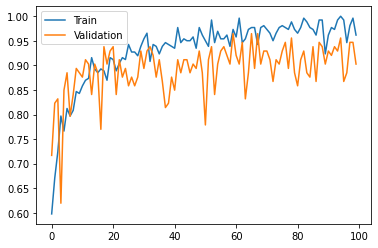

In [17]:
history = pd.DataFrame({"Train":TRAINING_acc,"Validation":VALIDATION_acc})
history.plot()

In [18]:
!ls

checkpoint_densenet161_1_0.71681.ph   checkpoint_densenet161_60_0.96460.ph
checkpoint_densenet161_12_0.91150.ph  checkpoint_densenet161_6_0.88496.ph
checkpoint_densenet161_18_0.93805.ph  checkpoint_densenet161_9_0.89381.ph
checkpoint_densenet161_2_0.82301.ph   OpticDiscs
checkpoint_densenet161_3_0.83186.ph   test_data.csv
checkpoint_densenet161_5_0.84956.ph


In [19]:
torch.save(model,"checkpoint.ph")

In [20]:
for c in y:
  print(c)

1


## Evaluation

In [22]:
model = torch.load('checkpoint_densenet161_60_0.96460.ph')

In [23]:
from sklearn.metrics import confusion_matrix
import numpy as np

In [24]:
predicted = []
true_values = []
for point in range(len(X_test)//batch_size):
    with torch.no_grad():

        X = X_test.iloc[point*batch_size:(point+1)*batch_size]
        y = y_test.iloc[point*batch_size:(point+1)*batch_size]

        true_values.append(y.values)
        # Load images
        try:
            images = [Image.open(File) for File in X]
        except:
            continue
        # Load y_true
        y_true = torch.LongTensor([c for c in y]).to(device)
        
        # Convert images to tensor
        x_batch = torch.FloatTensor().to(device)
        for image in images:
            P = composed(image).unsqueeze(0).to(device)
            x_batch = torch.cat((x_batch,P))

        
        outputs = model(x_batch)
        loss = criterion(outputs, y_true)
        
        _, preds = torch.max(outputs, 1)
        predicted.append(preds)

In [25]:
true_values = np.array(true_values).reshape(-1)
dummy = torch.FloatTensor().to(device)
for tensor in predicted:
    dummy = torch.cat((dummy,tensor))
predicted = dummy.view(-1).cpu().numpy()

In [26]:
confusion_matrix(true_values, predicted)

array([[44,  4],
       [ 0, 65]])